## XGBoost(eXtra Gradient Boost)의 개요 
트리 기반의 알고리즘의 앙상블 학습에서 각광받는 알고리즘 중 하나입니다.
GBM에 기반하고 있지만, GBM의 단점인 느린 수행시간, 과적합 규제 등을 해결한 알고리즘입니다.

(1) 뛰어난 예측 성능  
(2) GBM 대비 빠른 수행 시간  
(3) 과적합 규제(Overfitting Regularization)  
(4) Tree pruning(트리 가지치기) : 가지치기해서 분할 수를 줄임  
(5) 자체 내장된 교차 검증
- 반복 수행시마다 내부적으로 교차검증을 수행해 최적회된 반복 수행횟수를 가질 수 있음
- 지정된 반복횟수가 아니라 교차검증을 통해 평가 데이트세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 기능이 있음   

(6) 결손값 자체 처리  
 XGBoost는 독자적인 XGBoost 모듈과 사이킷런 프레임워크 기반의 모듈이 존재합니다.
독자적인 모듈은 고유의 API와 하이퍼파라미터를 사용하지만, 사이킷런 기반 모듈에서는 다른 Estimator와 동일한 사용법을 가지고 있습니다.

In [4]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [7]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [8]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400

In [9]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[15:00:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0

[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:

[330]	train-logloss:0.00533	eval-logloss:0.08587
[331]	train-logloss:0.00532	eval-logloss:0.08589
[332]	train-logloss:0.00532	eval-logloss:0.08592
[333]	train-logloss:0.00531	eval-logloss:0.08584
[334]	train-logloss:0.00531	eval-logloss:0.08574
[335]	train-logloss:0.00530	eval-logloss:0.08582
[336]	train-logloss:0.00529	eval-logloss:0.08589
[337]	train-logloss:0.00529	eval-logloss:0.08594
[338]	train-logloss:0.00528	eval-logloss:0.08583
[339]	train-logloss:0.00528	eval-logloss:0.08591
[340]	train-logloss:0.00527	eval-logloss:0.08583
[341]	train-logloss:0.00526	eval-logloss:0.08573
[342]	train-logloss:0.00526	eval-logloss:0.08568
[343]	train-logloss:0.00525	eval-logloss:0.08572
[344]	train-logloss:0.00525	eval-logloss:0.08580
[345]	train-logloss:0.00524	eval-logloss:0.08582
[346]	train-logloss:0.00524	eval-logloss:0.08571
[347]	train-logloss:0.00523	eval-logloss:0.08579
[348]	train-logloss:0.00523	eval-logloss:0.08583
[349]	train-logloss:0.00522	eval-logloss:0.08573
[350]	train-logloss:

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [11]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [12]:
get_clf_eval(y_test, preds)

오차행렬:
 [[35  2]
 [ 1 76]]

정확도: 0.9737
정밀도: 0.9744
재현율: 0.9870
F1: 0.9806
AUC: 0.9665


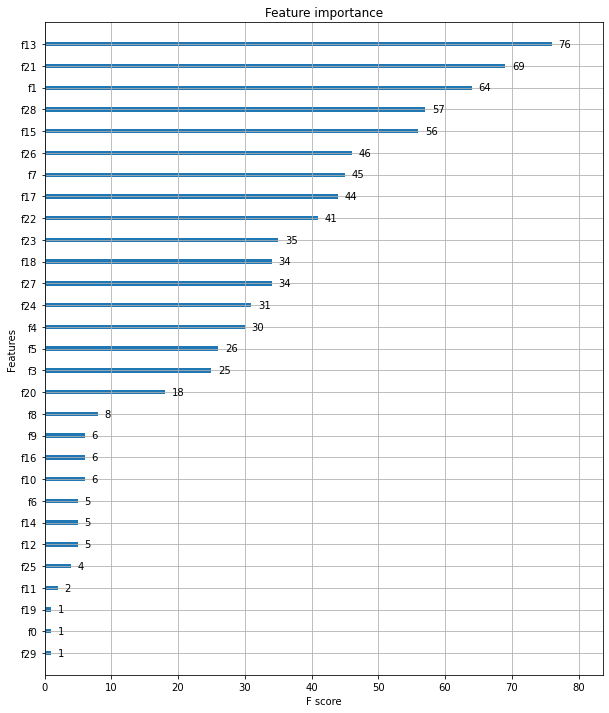

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)